## Creating Datasets

In [81]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import os
import numpy as np

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)

1.8.0


In [93]:
class CocoDataset(Dataset):
    def __init__(self, path2listFile, transform=None, trans_params=None):
        # get list of images
        with open(path2listFile, "r") as file:
            self.path2imgs = file.readlines()
        
        # get list of labels
        self.path2labels = [
            path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")
            for path in self.path2imgs]

        self.trans_params = trans_params
        self.transform = transform

    def __len__(self):
        return len(self.path2imgs)
    
    def __getitem__(self, index):
        path2img = self.path2imgs[index % len(self.path2imgs)].rstrip()

        img = Image.open(path2img).convert('RGB')

        path2label = self.path2labels[index % len(self.path2imgs)].rstrip()

        labels= None
        if os.path.exists(path2label):
            labels = np.loadtxt(path2label).reshape(-1, 5)
            
        if self.transform:
            img, labels = self.transform(img, labels, self.trans_params)

        return img, labels, path2img  

In [94]:
root_data="C:/Users/HeoJiHae/Downloads/darknet-master/scripts/coco"
path2trainList=os.path.join(root_data, "trainvalno5k.txt")
coco_train = CocoDataset(path2trainList)
print(len(coco_train))

117264


In [95]:
CocoDataset(path2trainList)

In [98]:
img, labels, path2img = coco_train[2] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)
#print(path2labels)
print(path2img)

image size: (640, 428) <class 'PIL.Image.Image'>
labels shape: (2, 5) <class 'numpy.ndarray'>
labels 
 [[58.        0.519219  0.451121  0.39825   0.75729 ]
 [75.        0.501188  0.592138  0.26      0.456192]]
C:/Users/HeoJiHae/Downloads/darknet-master/scripts/coco/images/train2014/COCO_train2014_000000000030.jpg


In [20]:
path2labels.rstrip()

'C:/Users/HeoJiHae/Downloads/darknet-master/scripts/coco/labels/val2014/COCO_val2014_000000000757.txt'

In [21]:
coco_train[1]

(<PIL.Image.Image image mode=RGB size=640x426 at 0x1C2E5ADD3A0>,
 array([[23.      ,  0.770336,  0.489695,  0.335891,  0.697559],
        [23.      ,  0.185977,  0.901608,  0.206297,  0.129554]]),
 'C:/Users/HeoJiHae/Downloads/darknet-master/scripts/coco/images/train2014/COCO_train2014_000000000025.jpg')

In [22]:
path2valList=os.path.join(root_data, "5k.txt")
coco_val = CocoDataset(path2valList, transform=None, trans_params=None)
print(len(coco_val))

5000


In [23]:
img, labels,path2img = coco_val[7] 
print("image size:", img.size, type(img))
print("labels shape:", labels.shape, type(labels))
print("labels \n", labels)

image size: (640, 427) <class 'PIL.Image.Image'>
labels shape: (3, 5) <class 'numpy.ndarray'>
labels 
 [[20.        0.539742  0.521429  0.758641  0.957143]
 [20.        0.403469  0.470714  0.641656  0.695948]
 [20.        0.853039  0.493279  0.293922  0.982061]]


In [24]:
import matplotlib.pylab as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_pil_image
import random
%matplotlib inline

In [25]:
path2cocoNames="C:/Users/HeoJiHae/Downloads/darknet-master/data/coco.names"
fp = open(path2cocoNames, "r")
coco_names = fp.read().split("\n")[:-1] # 뒤에 공백이 하나 있음
print("number of classese:", len(coco_names))
print(coco_names)

number of classese: 80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [86]:
coco_names[43:46]

['knife', 'spoon', 'bowl']

In [26]:
def rescale_bbox(bb,W,H):
    x,y,w,h=bb
    return [x*W, y*H, w*W, h*H]

In [27]:
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
fnt = ImageFont.truetype('/root/pyscripts/arial.ttf', 16)
def show_img_bbox(img,targets):
    if torch.is_tensor(img):
        img=to_pil_image(img)
    if torch.is_tensor(targets):
        targets=targets.numpy()[:,1:]
        
    W, H=img.size
    draw = ImageDraw.Draw(img)
    
    for tg in targets:
        id_=int(tg[0])
        bbox=tg[1:]
        bbox=rescale_bbox(bbox,W,H)
        xc,yc,w,h=bbox
        
        color = [int(c) for c in COLORS[id_]]
        name=coco_names[id_]
        
        draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)),outline=tuple(color),width=3)
        draw.text((xc-w/2,yc-h/2),name, font=fnt, fill=(255,255,255,0))
    plt.imshow(np.array(img))        

(640, 428) (2, 5)


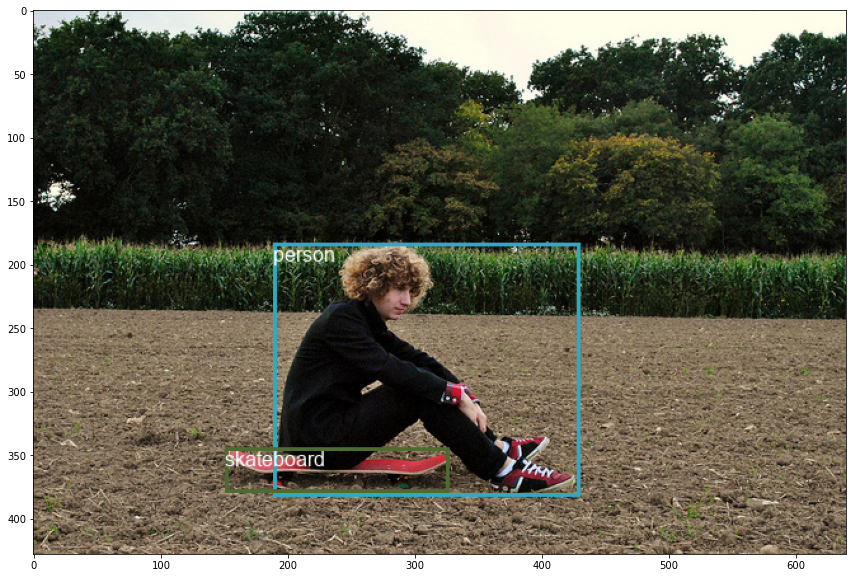

In [28]:
np.random.seed(2)
rnd_ind=np.random.randint(len(coco_train))
img, labels, path2img = coco_train[rnd_ind] 
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img,labels)

(640, 480) (3, 5)


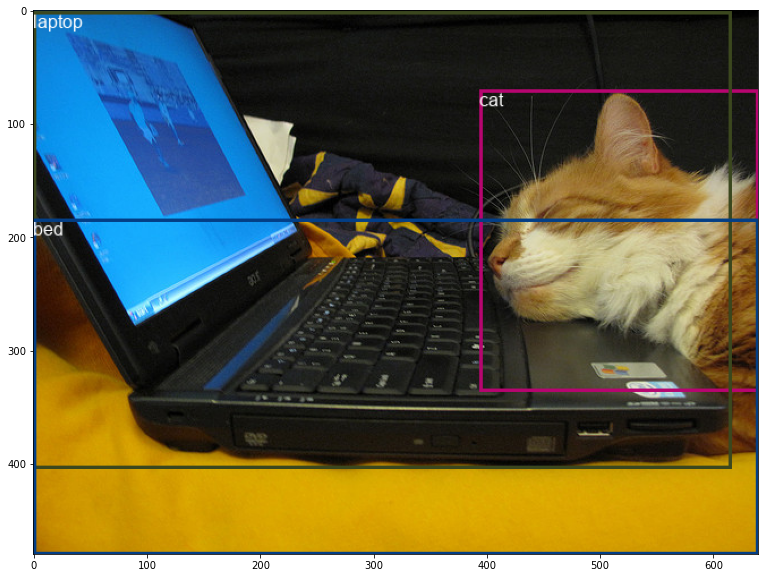

In [29]:
np.random.seed(0)
rnd_ind=np.random.randint(len(coco_val))
img, labels, path2img = coco_val[rnd_ind] 
print(img.size, labels.shape)

plt.rcParams['figure.figsize'] = (20, 10)
show_img_bbox(img,labels)

### Transforming the Data

In [30]:
def pad_to_square(img, boxes, pad_value=0, normalized_labels=True):
    w, h = img.size
    w_factor, h_factor = (w,h) if normalized_labels else (1, 1)
    
    dim_diff = np.abs(h - w)
    pad1= dim_diff // 2
    pad2= dim_diff - pad1
    
    if h<=w:
        left, top, right, bottom= 0, pad1, 0, pad2
    else:
        left, top, right, bottom= pad1, 0, pad2, 0
    padding= (left, top, right, bottom)

    img_padded = TF.pad(img, padding=padding, fill=pad_value)
    w_padded, h_padded = img_padded.size
            
    x1 = w_factor * (boxes[:, 1] - boxes[:, 3] / 2)
    y1 = h_factor * (boxes[:, 2] - boxes[:, 4] / 2)
    x2 = w_factor * (boxes[:, 1] + boxes[:, 3] / 2)
    y2 = h_factor * (boxes[:, 2] + boxes[:, 4] / 2)    
    
    x1 += padding[0] # left
    y1 += padding[1] # top
    x2 += padding[2] # right
    y2 += padding[3] # bottom
            
    boxes[:, 1] = ((x1 + x2) / 2) / w_padded
    boxes[:, 2] = ((y1 + y2) / 2) / h_padded
    boxes[:, 3] *= w_factor / w_padded
    boxes[:, 4] *= h_factor / h_padded

    return img_padded, boxes    

In [31]:
def hflip(image, labels):
    image = TF.hflip(image)
    labels[:, 1] = 1.0 - labels[:, 1]
    return image, labels

In [32]:
def transformer(image, labels, params):
    if params["pad2square"] is True:
        image,labels= pad_to_square(image, labels)
    
    image = TF.resize(image,params["target_size"])

    if random.random() < params["p_hflip"]:
        image,labels=hflip(image,labels)

    image=TF.to_tensor(image)
    targets = torch.zeros((len(labels), 6))
    targets[:, 1:] = torch.from_numpy(labels)
    
    return image, targets

In [33]:
trans_params_train={
    "target_size" : (416, 416),
    "pad2square": True,
    "p_hflip" : 1.0,
    "normalized_labels": True,
}
coco_train= CocoDataset(path2trainList, 
                        transform=transformer,
                         trans_params=trans_params_train)

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([2, 6])


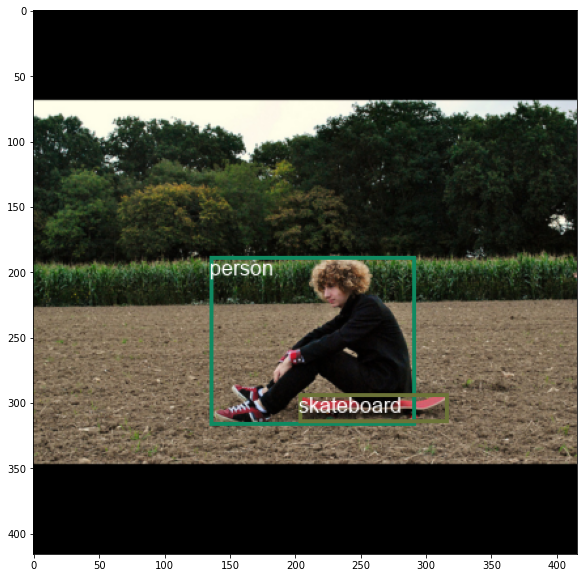

In [34]:
np.random.seed(2)
rnd_ind=np.random.randint(len(coco_train))
img, targets, path2img = coco_train[rnd_ind] 
print("image shape:", img.shape)
print("labels shape:", targets.shape) 

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
show_img_bbox(img,targets)

In [35]:
trans_params_val={
    "target_size" : (416, 416),
    "pad2square": True,
    "p_hflip" : 0.0,
    "normalized_labels": True,
}
coco_val= CocoDataset(path2valList,
                      transform=transformer,
                      trans_params=trans_params_val)

image shape: torch.Size([3, 416, 416])
labels shape: torch.Size([3, 6])


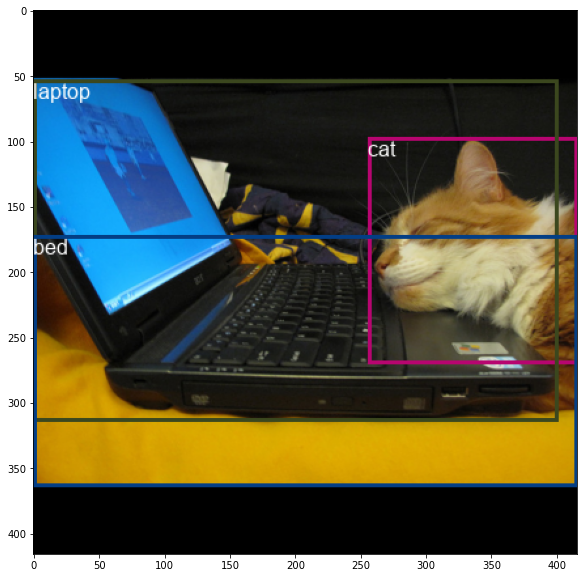

In [36]:
np.random.seed(0)
rnd_ind=np.random.randint(len(coco_val))
img, targets, path2img = coco_val[rnd_ind] 
print("image shape:", img.shape)
print("labels shape:", targets.shape) 

plt.rcParams['figure.figsize'] = (20, 10)
COLORS = np.random.randint(0, 255, size=(80, 3),dtype="uint8")
show_img_bbox(img,targets)

### Defining Data Loaders

In [37]:
from torch.utils.data import DataLoader

batch_size=8
def collate_fn(batch):
    imgs, targets, paths = list(zip(*batch))
    
    # Remove empty boxes
    targets = [boxes for boxes in targets if boxes is not None]
    
    # set the sample index 
    for b_i, boxes in enumerate(targets):
        boxes[:, 0] = b_i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, paths

train_dl = DataLoader(
        coco_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn,
        )



In [38]:
torch.manual_seed(0)
for imgs_batch,tg_batch,path_batch in train_dl:
    break
print(imgs_batch.shape)
print(tg_batch.shape,tg_batch.dtype)

torch.Size([8, 3, 416, 416])
torch.Size([82, 6]) torch.float32


In [39]:
val_dl = DataLoader(
        coco_val,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn,
        )

In [40]:
torch.manual_seed(0)
for imgs_batch,tg_batch,path_batch in val_dl:
    break
print(imgs_batch.shape)
print(tg_batch.shape,tg_batch.dtype)

torch.Size([8, 3, 416, 416])
torch.Size([83, 6]) torch.float32


## Creating YOLO-v3 Model

In [50]:

def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines]  # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['):  # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs


def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options

In [63]:
from myutils2 import *

In [64]:
# import myutils
# from myutils import parse_model_config

path2config="C:/Users/HeoJiHae/Downloads/darknet-master/cfg/yolov3.cfg"
blocks_list = parse_model_config(path2config)
blocks_list[:2]

[{'type': 'net',
  'batch': '64',
  'subdivisions': '16',
  'width': '608',
  'height': '608',
  'channels': '3',
  'momentum': '0.9',
  'decay': '0.0005',
  'angle': '0',
  'saturation': '1.5',
  'exposure': '1.5',
  'hue': '.1',
  'learning_rate': '0.001',
  'burn_in': '1000',
  'max_batches': '500200',
  'policy': 'steps',
  'steps': '400000,450000',
  'scales': '.1,.1'},
 {'type': 'convolutional',
  'batch_normalize': '1',
  'filters': '32',
  'size': '3',
  'stride': '1',
  'pad': '1',
  'activation': 'leaky'}]

### Creating PyTorch modules

In [66]:
from myutils2 import create_layers

hy_pa, m_l= create_layers(blocks_list)
print(m_l)
print(hy_pa)

ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_0): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_1): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_2): LeakyReLU(negative_slope=0.1)
  )
  (3): Sequential(
    (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_3): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leaky_3):

### Defining Darknet Model

In [67]:
import torch.nn as nn
class Darknet(nn.Module):
    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.blocks_list = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_layers(self.blocks_list)
        self.img_size = img_size
        
    def forward(self, x):
        img_dim = x.shape[2]
        layer_outputs, yolo_outputs = [], []
        
        for block, module in zip(self.blocks_list[1:], self.module_list):
            if block["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)        
                
                
            elif block["type"] == "shortcut":
                layer_ind = int(block["from"])
                x = layer_outputs[-1] + layer_outputs[layer_ind]
            elif block["type"] == "yolo":
                x= module[0](x)
                yolo_outputs.append(x)
            elif block["type"] == "route":
                x = torch.cat([layer_outputs[int(l_i)] 
                               for l_i in block["layers"].split(",")], 1)
            layer_outputs.append(x)
        yolo_out_cat = torch.cat(yolo_outputs, 1)
        return yolo_out_cat, yolo_outputs        
    
    

In [68]:
model = Darknet(path2config).to(device)
print(model)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [69]:
print(next(model.parameters()).device)

cuda:0


In [70]:
dummy_img=torch.rand(1,3,416,416).to(device)
with torch.no_grad():
    dummy_out_cat, dummy_out=model.forward(dummy_img)
    print(dummy_out_cat.shape)
    print(dummy_out[0].shape,dummy_out[1].shape,dummy_out[2].shape)

torch.Size([1, 10647, 85])
torch.Size([1, 507, 85]) torch.Size([1, 2028, 85]) torch.Size([1, 8112, 85])


## Defining the Loss Function

In [71]:
def get_loss_batch(output,targets, params_loss, opt=None):
    ignore_thres=params_loss["ignore_thres"]
    scaled_anchors= params_loss["scaled_anchors"]    
    mse_loss= params_loss["mse_loss"]
    bce_loss= params_loss["bce_loss"]
    
    num_yolos=params_loss["num_yolos"]
    num_anchors= params_loss["num_anchors"]
    obj_scale= params_loss["obj_scale"]
    noobj_scale= params_loss["noobj_scale"]
    
    loss=0.0
    for yolo_ind in range(num_yolos):
        yolo_out=output[yolo_ind]
        batch_size, num_bbxs, _=yolo_out.shape
        
        # get grid size
        gz_2=num_bbxs/num_anchors
        grid_size=int(np.sqrt(gz_2))
        
        yolo_out=yolo_out.view(batch_size,num_anchors,grid_size,grid_size,-1)
        
        pred_boxes=yolo_out[:,:,:,:,:4]
        x,y,w,h= transform_bbox(pred_boxes, scaled_anchors[yolo_ind])
        pred_conf=yolo_out[:,:,:,:,4]
        pred_cls_prob=yolo_out[:,:,:,:,5:]
        
        yolo_targets = get_yolo_targets({
                                            "pred_cls_prob": pred_cls_prob,
                                            "pred_boxes":pred_boxes,    
                                            "targets": targets,    
                                            "anchors": scaled_anchors[yolo_ind],    
                                            "ignore_thres": ignore_thres,
                                        }) 
        
        obj_mask=yolo_targets["obj_mask"]        
        noobj_mask=yolo_targets["noobj_mask"]            
        tx=yolo_targets["tx"]                
        ty=yolo_targets["ty"]                    
        tw=yolo_targets["tw"]                        
        th=yolo_targets["th"]                            
        tcls=yolo_targets["tcls"]                                
        t_conf=yolo_targets["t_conf"]
        
        loss_x = mse_loss(x[obj_mask], tx[obj_mask])
        loss_y = mse_loss(y[obj_mask], ty[obj_mask])
        loss_w = mse_loss(w[obj_mask], tw[obj_mask])
        loss_h = mse_loss(h[obj_mask], th[obj_mask])
        
        loss_conf_obj = bce_loss(pred_conf[obj_mask], t_conf[obj_mask])
        loss_conf_noobj = bce_loss(pred_conf[noobj_mask], t_conf[noobj_mask])
        loss_conf = obj_scale * loss_conf_obj + noobj_scale * loss_conf_noobj
        loss_cls = bce_loss(pred_cls_prob[obj_mask], tcls[obj_mask])
        loss += loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls
        
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item()        

In [72]:
def transform_bbox(bbox, anchors):
    x=bbox[:,:,:,:,0]
    y=bbox[:,:,:,:,1]
    w=bbox[:,:,:,:,2]
    h=bbox[:,:,:,:,3]
    anchor_w = anchors[:, 0].view((1, 3, 1, 1))
    anchor_h = anchors[:, 1].view((1, 3, 1, 1))       
    
    x=x-x.floor()
    y=y-y.floor()
    w= torch.log(w / anchor_w + 1e-16)
    h= torch.log(h / anchor_h + 1e-16)
    return x, y, w, h

In [73]:
def get_yolo_targets(params):
    pred_boxes=params["pred_boxes"]
    pred_cls_prob=params["pred_cls_prob"]
    target=params["targets"]
    anchors=params["anchors"] 
    ignore_thres=params["ignore_thres"] 

    batch_size = pred_boxes.size(0)
    num_anchors = pred_boxes.size(1)
    grid_size = pred_boxes.size(2)
    num_cls = pred_cls_prob.size(-1)
    
    
    sizeT=batch_size, num_anchors, grid_size, grid_size
    obj_mask = torch.zeros(sizeT,device=device,dtype=torch.uint8)
    noobj_mask = torch.ones(sizeT,device=device,dtype=torch.uint8)
    tx = torch.zeros(sizeT, device=device, dtype=torch.float32)
    ty= torch.zeros(sizeT, device=device, dtype=torch.float32)
    tw= torch.zeros(sizeT, device=device, dtype=torch.float32)
    th= torch.zeros(sizeT, device=device, dtype=torch.float32)
    
    sizeT=batch_size, num_anchors, grid_size, grid_size, num_cls
    tcls= torch.zeros(sizeT, device=device, dtype=torch.float32)
    
    target_bboxes = target[:, 2:] * grid_size
    t_xy = target_bboxes[:, :2]
    t_wh = target_bboxes[:, 2:]
    t_x, t_y = t_xy.t()
    t_w, t_h = t_wh.t()

    grid_i, grid_j = t_xy.long().t()
    
    iou_with_anchors=[get_iou_WH(anchor, t_wh) for anchor in anchors]
    iou_with_anchors = torch.stack(iou_with_anchors)
    best_iou_wa, best_anchor_ind = iou_with_anchors.max(0)
    
    batch_inds, target_labels = target[:, :2].long().t()
    obj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 1
    noobj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 0

    for ind, iou_wa in enumerate(iou_with_anchors.t()):
        noobj_mask[batch_inds[ind], iou_wa > ignore_thres, grid_j[ind], grid_i[ind]] = 0
        
        
    tx[batch_inds, best_anchor_ind, grid_j, grid_i] = t_x - t_x.floor()
    ty[batch_inds, best_anchor_ind, grid_j, grid_i] = t_y - t_y.floor()
    

    anchor_w=anchors[best_anchor_ind][:, 0]
    tw[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)
    
    anchor_h=anchors[best_anchor_ind][:, 1]
    th[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)
    
    tcls[batch_inds, best_anchor_ind, grid_j, grid_i, target_labels] = 1
    
    output={
        "obj_mask" : obj_mask,
        "noobj_mask" : noobj_mask,
        "tx": tx,
        "ty": ty,
        "tw": tw,
        "th": th,
        "tcls": tcls,
        "t_conf": obj_mask.float(),
    }
    return output    
        

In [74]:
def get_iou_WH(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

## Training the Model

In [75]:
def loss_epoch(model,params_loss,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    len_data=len(dataset_dl.dataset)
    running_metrics= {}
    
    for xb, yb,_ in dataset_dl:
        yb=yb.to(device)
        _,output=model(xb.to(device))
        loss_b=get_loss_batch(output,yb, params_loss,opt)
        running_loss+=loss_b
        if sanity_check is True:
            break 
    loss=running_loss/float(len_data)
    return loss

In [76]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    params_loss=params["params_loss"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    
    loss_history={
        "train": [],
        "val": [],
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf') 
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 
        model.train()
        train_loss=loss_epoch(model,params_loss,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)
        print("train loss: %.6f" %(train_loss))    
        
        model.eval()
        with torch.no_grad():
            val_loss=loss_epoch(model,params_loss,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        print("val loss: %.6f" %(val_loss))
        
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print("-"*10) 
    model.load_state_dict(best_model_wts)
    return model, loss_history            

In [77]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [78]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)
        
scaled_anchors=[model.module_list[82][0].scaled_anchors,
                model.module_list[94][0].scaled_anchors,
                model.module_list[106][0].scaled_anchors]        

In [79]:
mse_loss = nn.MSELoss(reduction="sum")
bce_loss = nn.BCELoss(reduction="sum")
params_loss={
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
} 

In [80]:
params_train={
    "num_epochs": 5,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}
model,loss_hist=train_val(model,params_train)

Epoch 0/4, current lr=0.001


RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 6.00 GiB total capacity; 4.51 GiB already allocated; 10.62 MiB free; 4.58 GiB reserved in total by PyTorch)

## Deploying the Model

In [49]:
path2weights="./models/weights.pt"
model.load_state_dict(torch.load(path2weights))

FileNotFoundError: [Errno 2] No such file or directory: './models/weights.pt'

In [ ]:
img,tg,_=coco_val[4]
print(img.shape)
print(tg.shape)

In [ ]:
show_img_bbox(img,tg)

In [ ]:
model.eval()
with torch.no_grad():
    out,_=model(img.unsqueeze(0).to(device))
print(out.shape)

In [ ]:
def NonMaxSuppression(bbox_pred, obj_threshold=0.5, nms_thres=0.5):
    bbox_pred[..., :4] = xywh2xyxy(bbox_pred[..., :4])
    output = [None] * len(bbox_pred)
    
    for ind, bb_pr in enumerate(bbox_pred):
        bb_pr = bb_pr[bb_pr[:, 4] >= obj_threshold]
        
        if not bb_pr.size(0):
            continue
            
        score = bb_pr[:, 4] * bb_pr[:, 5:].max(1)[0]
        bb_pr = bb_pr[(-score).argsort()]
        
        cls_probs, cls_preds = bb_pr[:, 5:].max(1, keepdim=True)
        detections = torch.cat((bb_pr[:, :5], 
                                cls_probs.float(), 
                                cls_preds.float()), 1)
        
        bbox_nms = []
        while detections.size(0):
            high_iou_inds = bbox_iou(detections[0, :4].unsqueeze(0), 
                                     detections[:, :4]) > nms_thres
            
            cls_match_inds = detections[0, -1] == detections[:, -1]
            supp_inds = high_iou_inds & cls_match_inds
            
            ww = detections[supp_inds, 4]
            detections[0, :4] = (ww * detections[supp_inds, :4]).sum(0) / ww.sum()
            
            bbox_nms += [detections[0]]
            detections = detections[~supp_inds]
            
        if bbox_nms:
            output[ind] = torch.stack(bbox_nms)
            output[ind]=xyxyh2xywh(output[ind])
    return output            

In [ ]:
def xywh2xyxy(xywh):
    xyxy = xywh.new(xywh.shape)
    xyxy[..., 0] = xywh[..., 0] - xywh[..., 2] / 2.0
    xyxy[..., 1] = xywh[..., 1] - xywh[..., 3] / 2.0
    xyxy[..., 2] = xywh[..., 0] + xywh[..., 2] / 2.0
    xyxy[..., 3] = xywh[..., 1] + xywh[..., 3] / 2.0
    return xyxy

In [ ]:
def xyxyh2xywh(xyxy, image_size=416):
    xywh = torch.zeros(xyxy.shape[0],6)
    xywh[:,2] = (xyxy[:, 0] + xyxy[:, 2]) / 2./img_size
    xywh[:,3] = (xyxy[:, 1] + xyxy[:, 3]) / 2./img_size
    xywh[:,5] = (xyxy[:, 2] - xyxy[:, 0])/img_size 
    xywh[:,4] = (xyxy[:, 3] - xyxy[:, 1])/img_size
    xywh[:,1]= xyxy[:,6]    
    return xywh

In [ ]:
def bbox_iou(box1, box2):
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) \
                    *torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    b1_area = (b1_x2 - b1_x1 + 1.0) * (b1_y2 - b1_y1 + 1.0)
    b2_area = (b2_x2 - b2_x1 + 1.0) * (b2_y2 - b2_y1 + 1.0)
    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
    return iou

In [ ]:
img_size=416
out_nms=NonMaxSuppression(out.cpu())
print (out_nms[0].shape)

In [ ]:
show_img_bbox(img,out_nms[0])